In [4]:
#data handling
import pandas as pd
import numpy as np

#data visualization
import matplotlib.pyplot as plt
import seaborn as sns

#preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import label_binarize
from sklearn.preprocessing import MinMaxScaler

#feature selection
from sklearn.feature_selection import mutual_info_classif

#classification
from sklearn.multiclass import OneVsRestClassifier
from sklearn.ensemble import RandomForestClassifier

# performance metrics
from sklearn.metrics import balanced_accuracy_score,f1_score,precision_score, recall_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import roc_curve,auc
from sklearn.metrics import roc_auc_score


from sklearn.metrics import roc_curve, auc
from itertools import cycle
from mpl_toolkits.mplot3d import Axes3D

import lime
import lime.lime_tabular

In [5]:

#read data directly from a github repository

file_url='cancer_gene_expression.csv'

dataframe=pd.read_csv(file_url)


In [6]:
#let's check the number of samples and features
#note:the last column contain the labels. it is not considered as a feature

print(dataframe.shape)

(801, 8001)


In [7]:
#let's check some of the columns (first, second and third columns)
print(dataframe.columns[0:3])

Index(['gene_1', 'gene_2', 'gene_3'], dtype='object')


In [8]:
#lets check the name of the last column of this dataframe

dataframe.columns[-1]

'Cancer_Type'

In [9]:
#check for missing values
datanul=dataframe.isnull().sum()
g=[i for i in datanul if i>0]

print('columns with missing values:%d'%len(g))

columns with missing values:0


In [10]:
#let's check how many different cancer types are there in the data
#note: in this tutorial the cancer types will be referred to as classes or labels

print(dataframe['Cancer_Type'].value_counts())

Cancer_Type
BRCA    300
KIRC    146
LUAD    141
PRAD    136
COAD     78
Name: count, dtype: int64


<Axes: xlabel='Cancer_Type'>

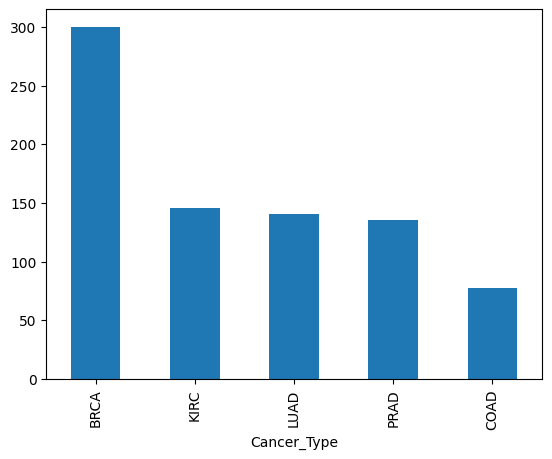

In [11]:
#plot a bar chat to display the class distribution

dataframe['Cancer_Type'].value_counts().plot.bar()


In [12]:
#we will now seperate the feature values from the class. we do this because scikit-learn requires that features and class are separated before parsing them to the classifiers.

X=dataframe.iloc[:,0:-1]
y=dataframe.iloc[:,-1]

In [13]:
X.shape

(801, 8000)

In [14]:
y.shape

(801,)

In [15]:
#let's encode target labels (y) with values between 0 and n_classes-1.
#encoding will be done using the LabelEncoder
label_encoder=LabelEncoder()
label_encoder.fit(y)
y_encoded=label_encoder.transform(y)
labels=label_encoder.classes_
classes=np.unique(y_encoded)

In [16]:
labels
print(labels)

['BRCA' 'COAD' 'KIRC' 'LUAD' 'PRAD']


In [17]:
classes

array([0, 1, 2, 3, 4])

In [18]:
#split data into training and test sets
X_train,X_test,y_train,y_test=train_test_split(X,y_encoded,test_size=0.2,random_state=42)

In [19]:
dataframe.iloc[:,0:10].describe()

,gene_1,gene_2,gene_3,gene_4,gene_5,gene_6,gene_7,gene_8,gene_9,gene_10
count,801.000000,801.000000,801.000000,801.000000,801.000000,801.000000,801.000000,801.000000,801.000000,801.000000
mean,0.026642,0.231049,0.010844,2.405459,0.005799,0.065640,0.022036,0.028394,0.703998,1.916364
std,0.136850,0.656692,0.153859,0.797236,0.052265,0.213557,0.148917,0.161606,0.779321,0.877010
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,1.898595,0.000000,0.000000,0.000000,0.000000,0.000000,1.357214
50%,0.000000,0.000000,0.000000,2.358284,0.000000,0.000000,0.000000,0.000000,0.518031,1.877862
75%,0.000000,0.000000,0.000000,2.929355,0.000000,0.000000,0.000000,0.000000,1.123931,2.486792
max,1.482332,6.575004,3.778061,4.746646,0.570754,1.866275,2.169925,2.375957,4.541670,4.932231


In [20]:
# scale data between 0 and 1

min_max_scaler=MinMaxScaler()

X_train_norm=min_max_scaler.fit_transform(X_train)
X_test_norm=min_max_scaler.fit_transform(X_test)

In [21]:
MI=mutual_info_classif(X_train_norm,y_train)

In [22]:
#select top n features. lets say 300.
#you can modify the value and see how the performance of the model changes

n_features=300
selected_scores_indices=np.argsort(MI)[::-1][0:n_features]

In [23]:
X_train_selected=X_train_norm[:,selected_scores_indices]
X_test_selected=X_test_norm[:,selected_scores_indices]

In [24]:
X_train_selected.shape

(640, 300)

In [25]:
X_test_selected.shape

(161, 300)

In [26]:
#Random Forest Classifier
#because we are dealing with multiclass data, the one versus rest strategy is used.
#learn to predict each class against the other.

RF=OneVsRestClassifier(RandomForestClassifier(max_features=0.2))
RF.fit(X_train_selected,y_train)
y_pred =RF.predict(X_test_selected)
pred_prob = RF.predict_proba(X_test_selected)

In [28]:
explainer = lime.lime_tabular.LimeTabularExplainer(X_train_selected, mode='classification', training_labels=y_train, feature_names=list(X_train.columns))

In [31]:
instance_idx = 0  # Choose the index of the instance for which you want an explanation
instance = X_test_selected[instance_idx]
explanation = explainer.explain_instance(instance, RF.predict_proba)


In [32]:
explanation.show_in_notebook()


In [ ]:
#accuracy
accuracy=np.round(balanced_accuracy_score(y_test,y_pred),4)
print('accuracy:%0.4f'%accuracy)

#precision
precision=np.round(precision_score(y_test,y_pred,average = 'weighted'),4)
print('precision:%0.4f'%precision)

#recall
recall=np.round(recall_score(y_test,y_pred,average = 'weighted'),4)
print('recall:%0.4f'%recall)

#f1score
f1score=np.round(f1_score(y_test,y_pred,average = 'weighted'),4)
print('f1score:%0.4f'%f1score)


report=classification_report(y_test,y_pred, target_names=labels)
print('\n')
print('classification report\n\n')
print(report)

accuracy:0.9429
precision:0.9646
recall:0.9627
f1score:0.9623


classification report


              precision    recall  f1-score   support

        BRCA       0.92      1.00      0.96        60
        COAD       1.00      0.88      0.93        16
        KIRC       1.00      0.96      0.98        28
        LUAD       0.95      0.88      0.91        24
        PRAD       1.00      1.00      1.00        33

    accuracy                           0.96       161
   macro avg       0.98      0.94      0.96       161
weighted avg       0.96      0.96      0.96       161



In [ ]:
#generate confusion matrix
cm=confusion_matrix(y_test,y_pred)
cm_df=pd.DataFrame(cm,index=labels,columns=labels)

In [ ]:
cm_df

,BRCA,COAD,KIRC,LUAD,PRAD
BRCA,60,0,0,0,0
COAD,1,14,0,1,0
KIRC,1,0,27,0,0
LUAD,3,0,0,21,0
PRAD,0,0,0,0,33


Text(50.722222222222214, 0.5, 'True Labels')

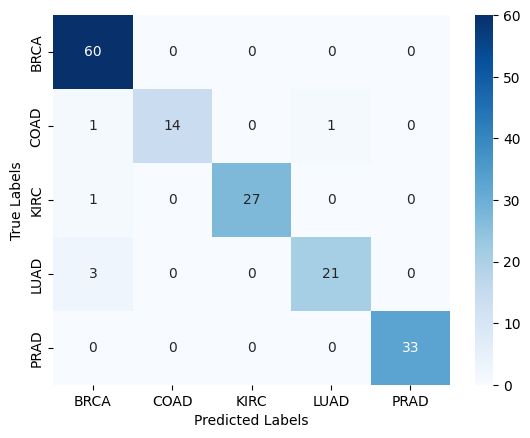

In [ ]:
#visualize the confusion matrix using seaborn

sns.heatmap(cm_df,annot=True,cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')

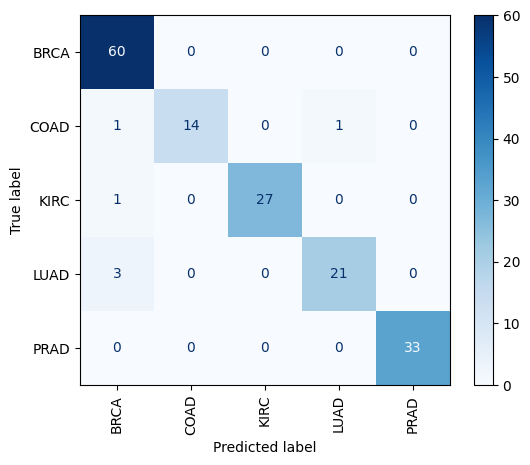

In [ ]:
# Assuming RF is your RandomForestClassifier, and X_test_selected and y_test are your test data
y_pred = RF.predict(X_test_selected)

# Compute confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Display the confusion matrix using ConfusionMatrixDisplay
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=labels)
disp.plot(cmap=plt.cm.Blues, xticks_rotation='vertical')
plt.show()

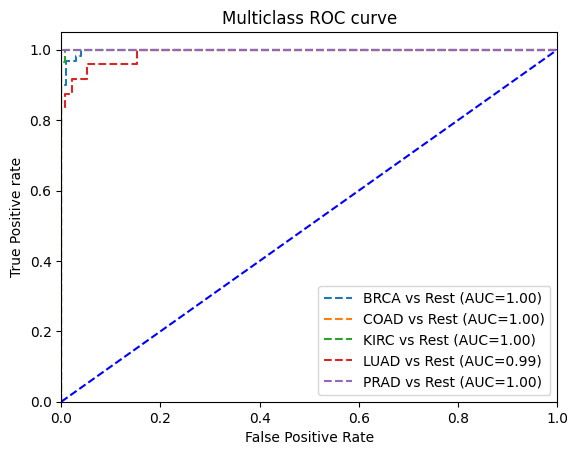

In [ ]:
#roc curves will be generated for each class
#we will therefore have to binarize the y_test labels
#this is done because the probabilities(pred_prob) are calculated for each each class
#we therefore need to put the y_test label in the same format as the pred_prob
y_test_binarized=label_binarize(y_test,classes=classes)

# roc curve for classes
fpr = {}
tpr = {}
thresh ={}
roc_auc = dict()

n_class = classes.shape[0]

for i in range(n_class):    
    fpr[i], tpr[i], thresh[i] = roc_curve(y_test_binarized[:,i], pred_prob[:,i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    # print(roc_auc[i])
    # print(fpr[i],tpr[i],thresh[i])
    # plotting    
    plt.plot(fpr[i], tpr[i], linestyle='--', 
             label='%s vs Rest (AUC=%0.2f)'%(labels[i],roc_auc[i]))
    

plt.plot([0,1],[0,1],'b--')
plt.xlim([0,1])
plt.ylim([0,1.05])
plt.title('Multiclass ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive rate')
plt.legend(loc='lower right')
plt.show()    

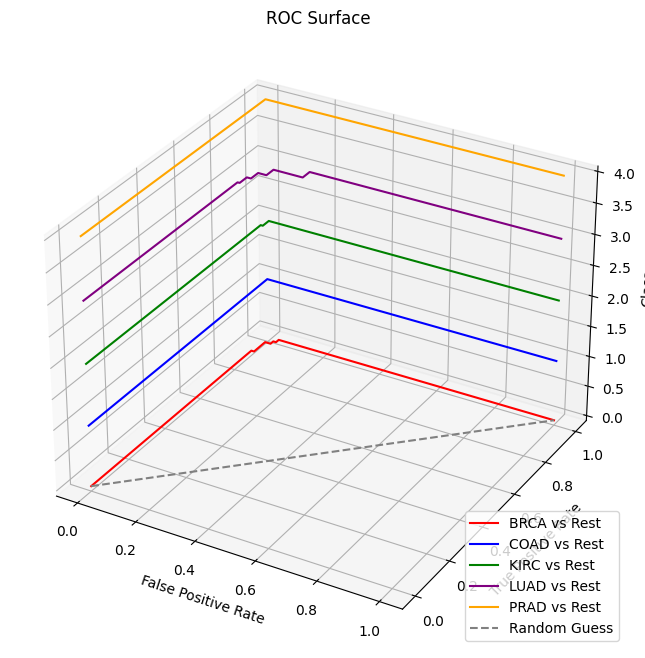

In [ ]:
# Assuming you have the true labels (y_test) and predicted probabilities (pred_prob) for each class

# Binarize the true labels
y_test_binarized = label_binarize(y_test, classes=np.unique(y_test))

# Initialize the figure
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# Set up color cycle for different classes
colors = cycle(['red', 'blue', 'green', 'purple', 'orange', 'yellow', 'cyan', 'magenta', 'brown', 'pink'])

# Plot ROC curves for each class
for i, color in zip(range(n_class), colors):
    fpr, tpr, _ = roc_curve(y_test_binarized[:, i], pred_prob[:, i])
    roc_auc = auc(fpr, tpr)
    ax.plot(fpr, tpr, zs=i, zdir='z', label=f'{labels[i]} vs Rest', color=color)

# Add a random guess line
ax.plot([0, 1], [0, 1], zs=0, zdir='z', linestyle='--', color='gray', label='Random Guess')

# Set labels and title
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_zlabel('Class')
ax.set_title('ROC Surface')

# Show the plot
plt.legend(loc='lower right')
plt.show()

In [79]:
RF.predict(X_test_selected[[1]])

import numpy as np

data_to_write = X_test_selected[0]

# Specify the file path
file_path = "PrevSample.txt"

# Write the data to the text file
np.savetxt(file_path, data_to_write, delimiter=',')


In [80]:
# Read the data from the text file into a NumPy array
loaded_data = np.loadtxt(file_path, delimiter=',')

# If loaded_data is 1D, reshape it to 2D
if len(loaded_data.shape) == 1:
    loaded_data = loaded_data.reshape(1, -1)

# Now, loaded_data contains the values from the text file
print("Loaded Data:")
print(loaded_data)

Loaded Data:
[[0.30933919 0.31532601 0.59223323 0.23144135 0.47009538 0.59028392
  0.13528766 0.65338714 0.38096734 0.42408375 0.96136997 0.378898
  0.46773117 0.48481016 0.6636932  0.4321008  0.39988658 0.20368035
  0.07881207 0.36346718 0.         0.5301967  0.54526884 0.
  0.2622395  0.58429417 0.         0.         0.55981451 0.64590256
  0.72488031 0.41659969 0.34245981 0.49758439 0.59221099 0.80777248
  0.50614796 0.20834614 0.46708198 0.45411598 0.28931037 0.34631697
  0.07049596 0.51339272 0.         0.52393819 0.38534585 0.81462662
  0.23556273 0.71652204 0.72871103 0.22618053 0.55735608 0.3744301
  0.06946629 0.4637467  0.58466895 0.31974608 0.36504164 0.
  0.         0.13521998 0.13438524 0.19547127 0.48455512 0.5797929
  0.33566844 0.25315133 0.07568744 0.38373839 0.37993217 0.55620197
  0.61628864 0.65327788 0.64558133 0.56081343 0.18411726 0.79158035
  0.11864367 0.61453577 0.56843172 0.42318167 0.2049626  0.
  0.57439468 0.44553073 0.34185674 0.4918071  1.         0.5649

In [89]:
kanker = ["BRCA","COAD","KIRC","LUAD","PRAD"]

In [90]:
#This is prediciting using the sample from the dataset
RF.predict(loaded_data)[0]

print("You might have", kanker[RF.predict(loaded_data)[0]])

You might have BRCA


In [91]:
# Read the data from the text file into a NumPy array
loaded_data = np.loadtxt("NewSample.txt", delimiter=',')

# If loaded_data is 1D, reshape it to 2D
if len(loaded_data.shape) == 1:
    loaded_data = loaded_data.reshape(1, -1)

# Now, loaded_data contains the values from the text file
print("Loaded New Sample:")
print(loaded_data)

Loaded New Sample:
[[0.82879032 0.27497503 0.79604949 0.82159691 0.33621224 0.9302548
  0.00244222 0.28996454 0.64258949 0.3183637  0.09419565 0.6775024
  0.34329066 0.36254377 0.69776916 0.72431582 0.66741183 0.68197399
  0.4692251  0.67663792 0.76068426 0.41924198 0.0685957  0.93245521
  0.05353802 0.16164539 0.74461518 0.06145497 0.48246173 0.21881617
  0.90621713 0.98827819 0.68519059 0.51385579 0.43483447 0.27155337
  0.20126675 0.24123022 0.58257349 0.81411396 0.76441264 0.84166717
  0.30019588 0.70397684 0.56754902 0.51675567 0.27148352 0.19599038
  0.00412563 0.84132748 0.61692456 0.79362059 0.67601411 0.48915581
  0.80112547 0.79184304 0.56668668 0.23982268 0.81277149 0.61182352
  0.57495324 0.98099537 0.4520749  0.88491105 0.4234751  0.64408457
  0.13689738 0.68304331 0.9554287  0.99755033 0.09878774 0.8702457
  0.22505886 0.5825353  0.65062735 0.39513719 0.117343   0.45100725
  0.49566296 0.08948952 0.77005287 0.57781709 0.12862728 0.35137031
  0.44941402 0.25225375 0.805759

In [92]:
#This is prediciting using the new generated sample
RF.predict(loaded_data)[0]

print("You might have", kanker[RF.predict(loaded_data)[0]])

You might have KIRC
